In [2245]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math

In [2246]:
df = pd.read_csv('mock_kaggle.csv')
df = df.rename(columns={'data': 'date','venda': 'sold', 'estoque': 'stock', 'preco': 'price'})

In [2247]:
df

,date,sold,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [2248]:
df = df[(df != 0).all(1)]
df

,date,sold,stock,price
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
5,2014-01-06,145,4509,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


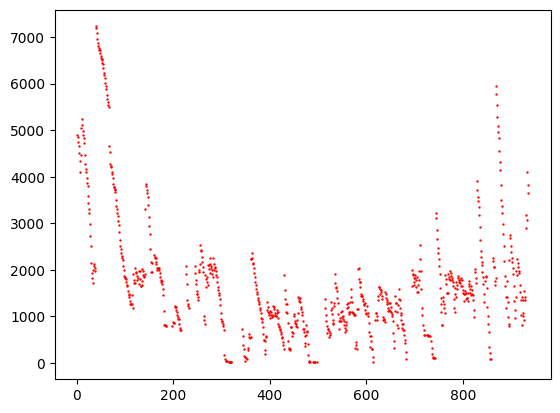

In [2249]:

x_price = df.index
y_price = df.stock

plt.scatter(x_price, y_price, s=0.5, color='red')

In [2250]:
def calculate_square_deviation(y_real, y_predict):
    deviation = 0
    for i in range(len(y_real)):
        dev = y_real[i] - y_predict[i]
        deviation += dev**2
    return deviation

In [2251]:
def coefficients_calculation(x_values, y_values):
    average_x = 0
    average_y = 0
    average_xy = 0
    average_xx = 0
    n = len(x_values)
    for i in range(n):
        average_x += x_values[i]
        average_y += y_values[i]
        average_xy += x_values[i]*y_values[i]
        average_xx += x_values[i]**2
    average_x = average_x/n
    average_y = average_y/n
    average_xy = average_xy/n
    average_xx = average_xx/n
    d_x = average_xx - average_x**2
    b = (average_xy - average_x*average_y)/d_x
    a = average_y - b * average_x
    return (a, b)

In [2252]:
linearization_funcs_data = pd.DataFrame(columns=['Linearization_func_name', 'square_deviation'])
linearization_funcs_data

,Linearization_func_name,square_deviation


Линейная y = a*x+b

In [ ]:
def graph(x_vals, y_vals):
    def y_transform_to_g(y):
        return y

    def x_transform_to_t(x):
        return x

    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d


    def y_final_formula(x):
        return c_to_a *x + d_to_b
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))


    square_dev = calculate_square_deviation(list(y_vals), final_y)

    new_data = {'Linearization_func_name': 'Линейная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y)  


graph(x_price, y_price)
plt.scatter(x_price, y_price, s=0.5, color='red')

Гиперболическая y = a + b/x 

transform to y = a + b * t where t = 1/x ; for lsm: a = c , b = d

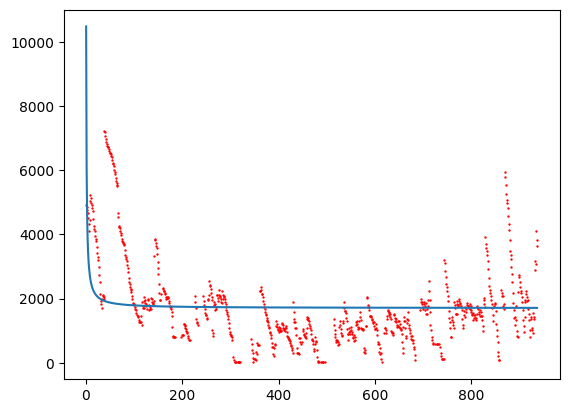

In [2253]:
def graph(x_vals, y_vals):
    def y_transform_to_g(y):
        return y

    def x_transform_to_t(x):
        return 1 / x


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d


    def y_final_formula(x):
        return c_to_a + d_to_b / x
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))


    square_dev = calculate_square_deviation(list(y_vals), final_y)

    new_data = {'Linearization_func_name': 'Гиперболическая', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y)  


graph(x_price, y_price)
plt.scatter(x_price, y_price, s=0.5, color='red')

Логарифмическая y = a + b * ln(x)

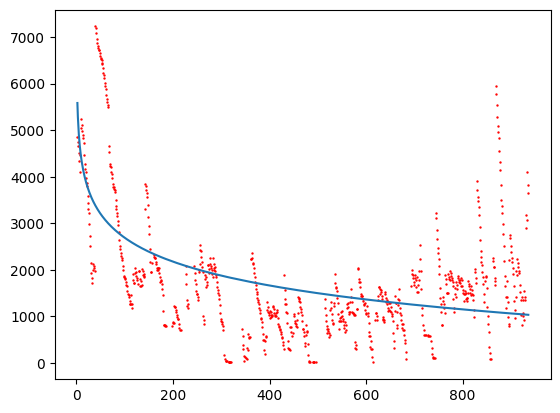

In [2254]:
def graph(x_vals, y_vals):
    def y_transform_to_g(y):
        return y

    def x_transform_to_t(x):
        return math.log(x, math.e)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d


    def y_final_formula(x):
        return c_to_a + d_to_b * math.log(x, math.e)
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Логарифмическая', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data


    plt.plot(x_vals, final_y)


graph(x_price[1:], y_price[1:])
plt.scatter(x_price[1:], y_price[1:], s=0.5, color='red')

Показательная y = a * e ^ (b*x)

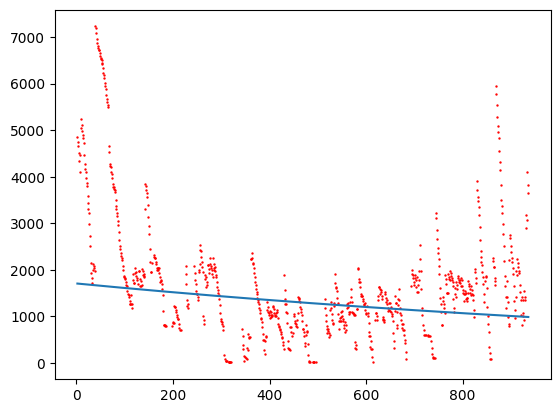

In [2255]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return math.log(y, math.e)

    def x_transform_to_t(x):
        return x


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = math.e**c
    d_to_b = d

    def y_final_formula(x):
        return c_to_a * math.e ** (d_to_b * x)
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Показательная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    plt.plot(x_vals, final_y)


graph(x_price[1:], y_price[1:])
plt.scatter(x_price[1:], y_price[1:], s=0.5, color='red')

Степенная y = a * x ^ b

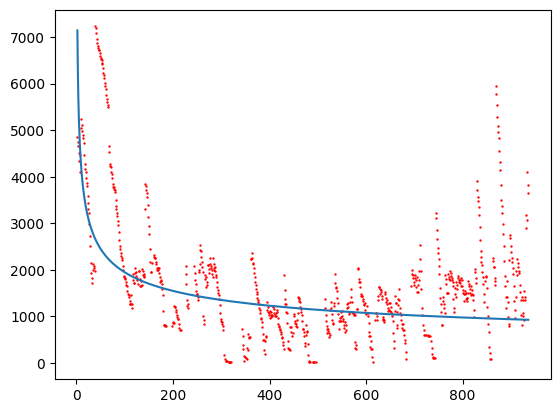

In [2256]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return math.log(y, math.e)

    def x_transform_to_t(x):
        return math.log(x, math.e)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = math.e**c
    d_to_b = d

    def y_final_formula(x):
        return c_to_a * x ** d_to_b
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Степенная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    
    plt.plot(x_vals, final_y)


graph(x_price[1:], y_price[1:])
plt.scatter(x_price[1:], y_price[1:], s=0.5, color='red')

Комбинированная y = 1 / (a+b*e^(-x))

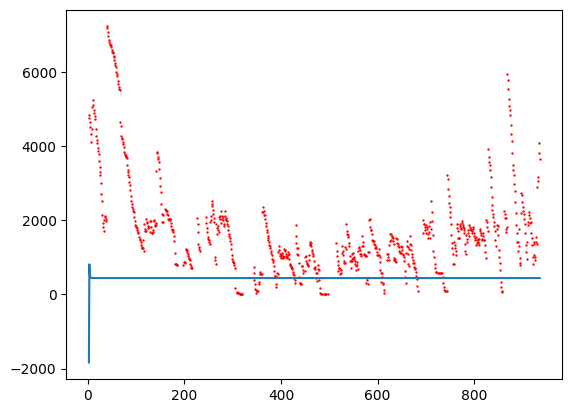

In [2257]:
def graph(x_vals, y_vals):  
    def y_transform_to_g(y):
        return 1/y

    def x_transform_to_t(x):
        return math.e ** (-x)


    t = []
    for x in x_vals:
        t.append(x_transform_to_t(x))

    g = []
    for y in y_vals:
        g.append(y_transform_to_g(y))  # <- note now we're calling the function 'formula' with x
    

    c,d = coefficients_calculation(t, g)
    
    c_to_a = c
    d_to_b = d

    def y_final_formula(x):
        return 1 / (c_to_a + d_to_b * math.e ** (-x))
    
    final_y = []
    for x in x_vals:
        final_y.append(y_final_formula(x))

    square_dev = calculate_square_deviation(list(y_vals), final_y)
    
    new_data = {'Linearization_func_name': 'Комбинированная', 'square_deviation': square_dev}
    linearization_funcs_data.loc[len(linearization_funcs_data)] = new_data

    
    plt.plot(x_vals, final_y)


graph(x_price[1:], y_price[1:])
plt.scatter(x_price[1:], y_price[1:], s=0.5, color='red')

In [2258]:
linearization_funcs_data

,Linearization_func_name,square_deviation
0,Гиперболическая,1.356492e+09
1,Логарифмическая,1.007979e+09
2,Показательная,1.507799e+09
3,Степенная,1.120139e+09
4,Комбинированная,2.921763e+09
